In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys, json, pickle, itertools, numpy as np, pandas as pd, scipy.sparse as sp
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import roc_auc_score
import networkx as nx

import torch, torch.nn as nn, torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

import dgl, dgl.nn.pytorch.conv as conv

import phate, umap

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

/Users/sumner/miniforge3/envs/gode/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from gode.utils import get_device

In [4]:
device = get_device()

# seed for repeatability
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

seed = 3
torch.manual_seed(seed)
np.random.seed(seed)

In [5]:
device

'cpu'

In [6]:
device = 'cpu'

# Load SERGIO Data

In [7]:
DATA_DIR = os.path.abspath('../simulations/SERGIO/data/DS12')

In [8]:
sim_data = np.load(
    os.path.join(DATA_DIR, 'SERGIO_sim_DS12.npy'),
    allow_pickle=True, encoding='bytes'
).item()

In [9]:
df_edges = pd.read_csv(
    os.path.join(DATA_DIR, 'gt_GRN.csv'), index_col=False, 
    header=None, names='u v'.split()
)
# _|_u_|_v_|

# Make Embeddings

In [10]:
X = sim_data[b'unspliced_expr']
(num_cell_types, num_genes, num_cells_per_type) = X.shape

mean_expr = np.mean(X, axis=2)

In [11]:
grn_graph = nx.Graph(list(df_edges.itertuples(index=False)))
grn_graph_pos = nx.spring_layout(grn_graph)

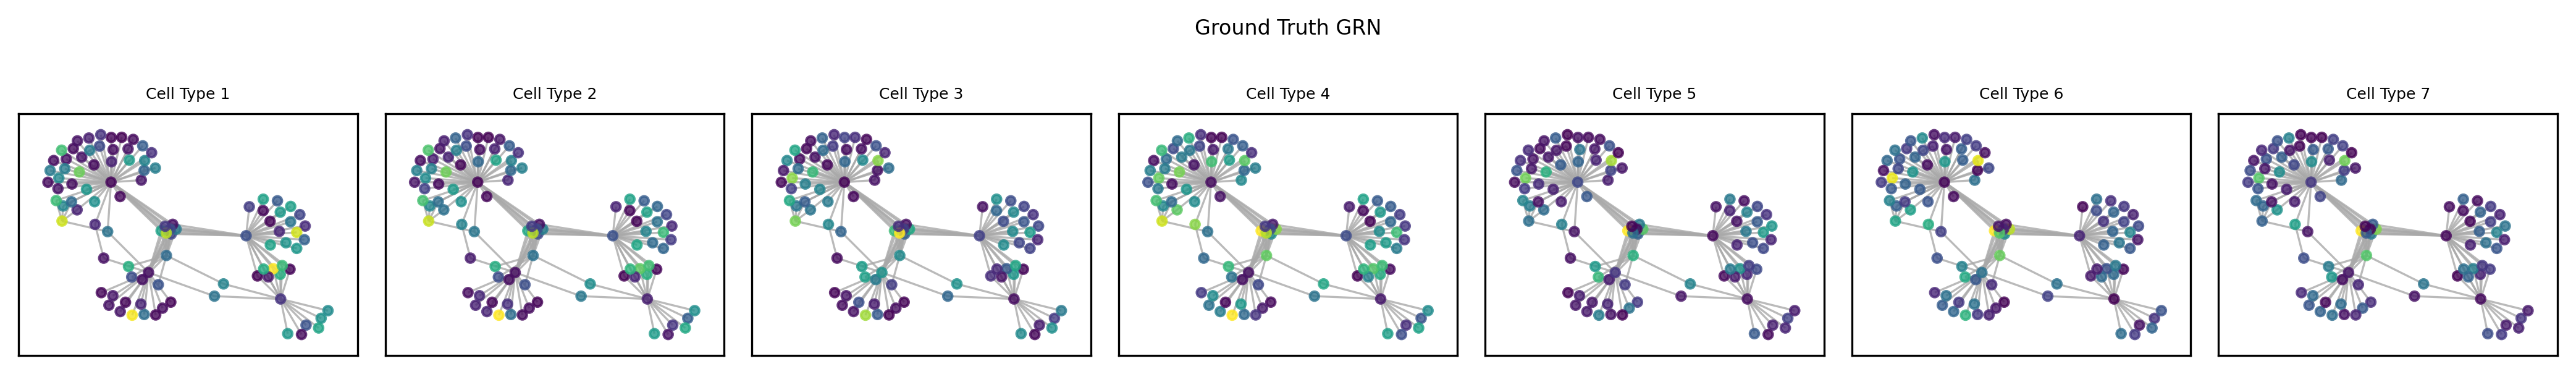

In [12]:
fig, axs = plt.subplots(1, num_cell_types, figsize=(2*num_cell_types,2.01), dpi=300)

for ctype in range(num_cell_types):
    nx.draw_networkx(
        grn_graph, pos=grn_graph_pos,
        node_size=12, node_color=mean_expr[ctype,:], 
        edge_color="darkgray", width=0.8,
        with_labels=False, font_size=3,   
        alpha=0.8, ax=axs[ctype]
    )
    axs[ctype].set_title(f"Cell Type {ctype+1}", fontsize=6)

fig.suptitle("Ground Truth GRN", fontsize=8)
plt.tight_layout()
plt.show()

In [13]:
X_all = np.concatenate(X, axis = 1)
scaled_X = StandardScaler().fit_transform(X_all.T)

In [14]:
pca = PCA(n_components=2)
X_PCA = pca.fit_transform(scaled_X)

In [15]:
phate_op = phate.PHATE()
X_PHATE = phate_op.fit_transform(scaled_X);

Calculating PHATE...
  Running PHATE on 2100 observations and 100 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.49 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 0.51 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.18 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.81 seconds.
  Calculated landmark operator in 4.80 seconds.
  Calculating optimal t...
    Automatically selected t = 28
  Calculated optimal t in 1.37 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.42 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.91 seconds.
Calculated PHATE in 10.03 seconds.


In [16]:
reducer = umap.UMAP()
X_UMAP = reducer.fit_transform(scaled_X);

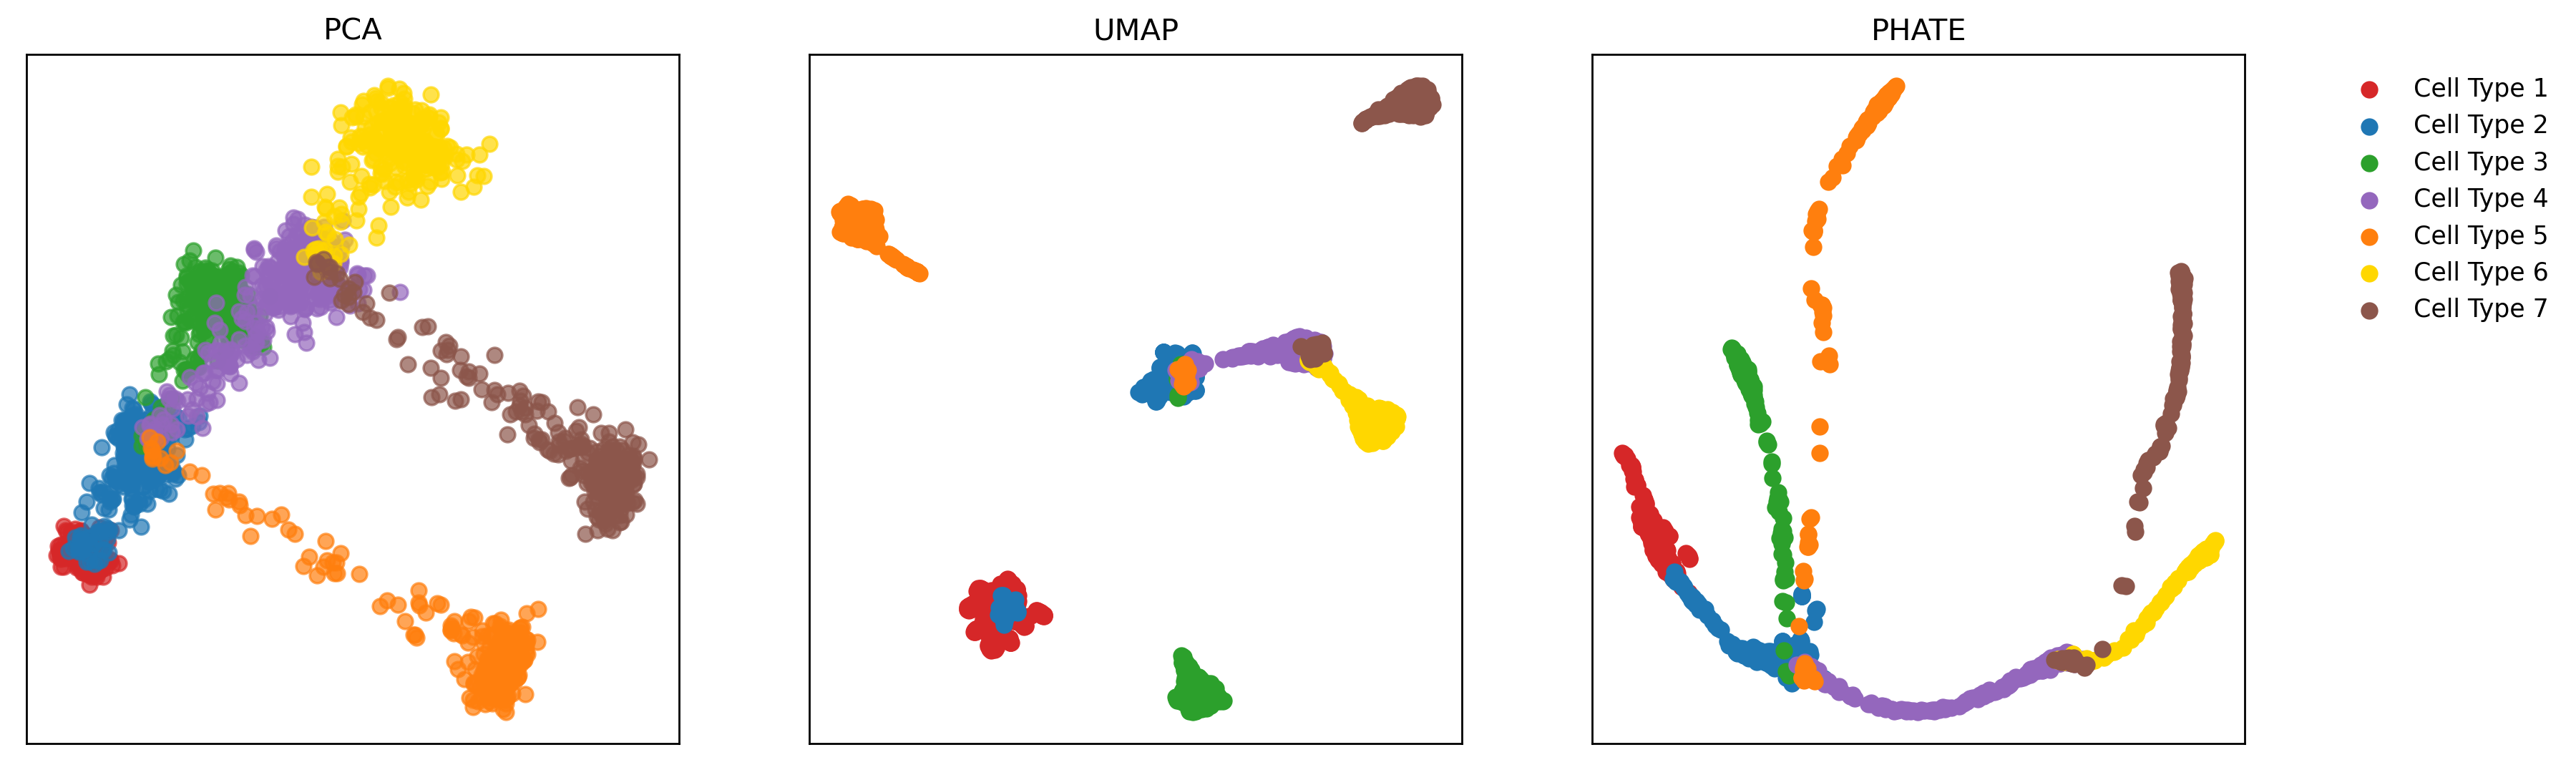

In [17]:
X_PCA_ctype = X_PCA.reshape((num_cell_types, num_cells_per_type, 2))
X_UMAP_ctype = X_UMAP.reshape((num_cell_types, num_cells_per_type, 2))
X_PHATE_ctype = X_PHATE.reshape((num_cell_types, num_cells_per_type, 2))

clr_order = ['#d62728', '#1f77b4', '#2ca02c', '#9467bd', '#ff7f0e', 'gold', '#8c564b']

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16,5), dpi=250)

for ctype in range(num_cell_types):
    axs[0].scatter(X_PCA_ctype[ctype,:,0], X_PCA_ctype[ctype,:,1], c=clr_order[ctype], alpha=0.7)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title("PCA")

for ctype in range(num_cell_types):
    axs[1].scatter(X_UMAP_ctype[ctype,:,0], X_UMAP_ctype[ctype,:,1], c=clr_order[ctype])
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("UMAP")

for ctype in range(num_cell_types):
    axs[2].scatter(X_PHATE_ctype[ctype,:,0], X_PHATE_ctype[ctype,:,1], c=clr_order[ctype], 
                   label=f"Cell Type {ctype+1}")
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title("PHATE")
axs[2].legend(bbox_to_anchor=(1.5, 1.0), loc=1, frameon=False)

plt.show()

In [18]:
scaled_X.shape

(2100, 100)

In [19]:
barcodes = pd.Series([
        f'cell_{i}' for i in range(scaled_X.shape[0])
    ], name='barcode'
)

cell_types = pd.Series([
        f'cell_type_{i}' 
        for i in range(num_cell_types)
        for j in range(num_cells_per_type) 
    ], name='cell_types', index=barcodes
)

gene_names = pd.Series([
        f'gene_{i}' 
        for i in range(scaled_X.shape[1])
    ], name='gene_names',
)

# Slingshot

In [20]:
!pip install git+https://github.com/mossjacob/pcurvepy
!pip install pyslingshot

  Cloning https://github.com/mossjacob/pcurvepy to /private/var/folders/9p/5wgy7cdj0fqft1h3t3ssh_8r0000gn/T/pip-req-build-l3t97n6a
  Running command git clone --filter=blob:none --quiet https://github.com/mossjacob/pcurvepy /private/var/folders/9p/5wgy7cdj0fqft1h3t3ssh_8r0000gn/T/pip-req-build-l3t97n6a
  Resolved https://github.com/mossjacob/pcurvepy to commit 620fb94272e653310ff9f464dc2cd00ea8d568b5
  Preparing metadata (setup.py) ... done


In [21]:
from slingshot import Slingshot

In [22]:
from slingshot import plotter

In [23]:
import math
from matplotlib.cm import hsv
from matplotlib.colors import ListedColormap

def generate_colormap(number_of_distinct_colors: int = 80):
    if number_of_distinct_colors == 0:
        number_of_distinct_colors = 80

    number_of_shades = 7
    number_of_distinct_colors_with_multiply_of_shades = int(math.ceil(number_of_distinct_colors / number_of_shades) * number_of_shades)

    # Create an array with uniformly drawn floats taken from <0, 1) partition
    linearly_distributed_nums = np.arange(number_of_distinct_colors_with_multiply_of_shades) / number_of_distinct_colors_with_multiply_of_shades

    # We are going to reorganise monotonically growing numbers in such way that there will be single array with saw-like pattern
    #     but each saw tooth is slightly higher than the one before
    # First divide linearly_distributed_nums into number_of_shades sub-arrays containing linearly distributed numbers
    arr_by_shade_rows = linearly_distributed_nums.reshape(number_of_shades, number_of_distinct_colors_with_multiply_of_shades // number_of_shades)

    # Transpose the above matrix (columns become rows) - as a result each row contains saw tooth with values slightly higher than row above
    arr_by_shade_columns = arr_by_shade_rows.T

    # Keep number of saw teeth for later
    number_of_partitions = arr_by_shade_columns.shape[0]

    # Flatten the above matrix - join each row into single array
    nums_distributed_like_rising_saw = arr_by_shade_columns.reshape(-1)

    # HSV colour map is cyclic (https://matplotlib.org/tutorials/colors/colormaps.html#cyclic), we'll use this property
    initial_cm = hsv(nums_distributed_like_rising_saw)
    
    lower_partitions_half = number_of_partitions // 2
    upper_partitions_half = number_of_partitions - lower_partitions_half

    # Modify lower half in such way that colours towards beginning of partition are darker
    # First colours are affected more, colours closer to the middle are affected less
    lower_half = lower_partitions_half * number_of_shades
    for i in range(3):
        if lower_half == 0:
            v = 0.8
        else :
            v = 0.8/lower_half
        initial_cm[0:lower_half, i] *= np.arange(0.2, 1, v)

    # Modify second half in such way that colours towards end of partition are less intense and brighter
    # Colours closer to the middle are affected less, colours closer to the end are affected more
    for i in range(3):
        for j in range(upper_partitions_half):
            modifier = np.ones(number_of_shades) - initial_cm[lower_half + j * number_of_shades: lower_half + (j + 1) * number_of_shades, i]
            modifier = j * modifier / upper_partitions_half
            initial_cm[lower_half + j * number_of_shades: lower_half + (j + 1) * number_of_shades, i] += modifier

    return ListedColormap(initial_cm)

In [24]:
plotter.generate_colormap = generate_colormap
Slingshot.plotter = plotter

In [25]:
cluster_labels_onehot = pd.get_dummies(cell_types).values
cluster_labels_onehot.shape

IN = X_PHATE_ctype.reshape(-1, 2)

Lineages: [Lineage[0, 1, 2], Lineage[0, 1, 3, 5], Lineage[0, 1, 3, 6], Lineage[0, 1, 4]]


  0%|                                                                          | 0/1 [00:00<?, ?it/s]

Reversing from leaf to root
Averaging branch @3 with lineages: [1, 2] [<pcurve.pcurve.PrincipalCurve object at 0x166604580>, <pcurve.pcurve.PrincipalCurve object at 0x1666041f0>]
Averaging branch @1 with lineages: [0, 1, 2, 3] [<pcurve.pcurve.PrincipalCurve object at 0x1666f9fc0>, <pcurve.pcurve.PrincipalCurve object at 0x166606ce0>, <pcurve.pcurve.PrincipalCurve object at 0x16653ba60>]
Shrinking branch @1 with curves: [<pcurve.pcurve.PrincipalCurve object at 0x1666f9fc0>, <pcurve.pcurve.PrincipalCurve object at 0x166606ce0>, <pcurve.pcurve.PrincipalCurve object at 0x16653ba60>]
Shrinking branch @3 with curves: [<pcurve.pcurve.PrincipalCurve object at 0x166604580>, <pcurve.pcurve.PrincipalCurve object at 0x1666041f0>]


100%|██████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.79s/it]


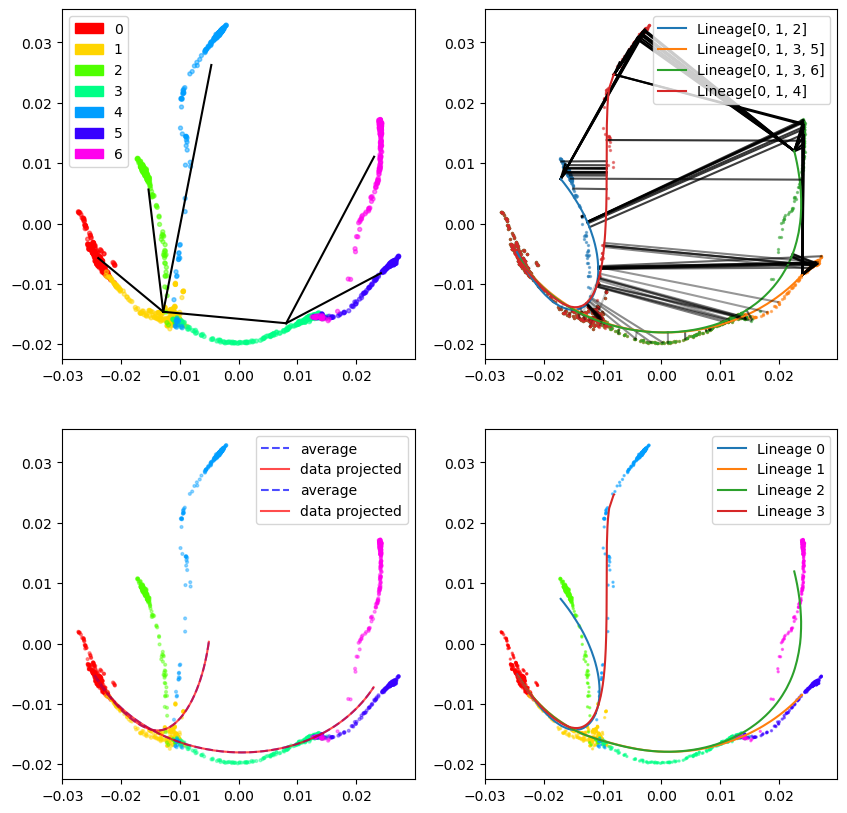

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
custom_xlim = (-12, 12)
custom_ylim = (-12, 12)
# plt.setp(axes, xlim=custom_xlim, ylim=custom_ylim)



slingshot = Slingshot(
    IN, 
    cluster_labels_onehot, 
    start_node=0, 
#     end_nodes=[(num_cell_types - 1) * num_cells_per_type - 1, num_cell_types * num_cells_per_type - 1], 
    debug_level='verbose',
)

slingshot.fit(num_epochs=1, debug_axes=axes)


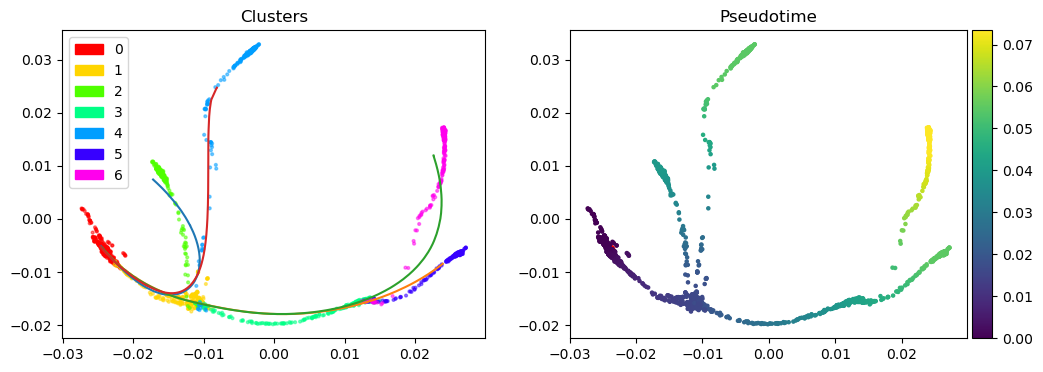

In [27]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
axes[0].set_title('Clusters')
axes[1].set_title('Pseudotime')
slingshot.plotter.curves(axes[0], slingshot.curves)
slingshot.plotter.clusters(axes[0], labels=np.arange(slingshot.num_clusters), s=4, alpha=0.5)
slingshot.plotter.clusters(axes[1], color_mode='pseudotime', s=5)

In [28]:
colors = np.zeros_like(slingshot.curves[0].pseudotimes_interp)
for l_idx, lineage in enumerate(slingshot.lineages):
    curve = slingshot.curves[l_idx]
    cell_mask = np.logical_or.reduce(
        np.array([slingshot.cluster_labels == k for k in lineage]))
    colors[cell_mask] = curve.pseudotimes_interp[cell_mask]

In [29]:
pseudotime = pd.Series(colors, name='pseudotime', index=barcodes)

# Create DataFrames

In [34]:
df_data = pd.DataFrame(
    scaled_X, 
    index=barcodes,
    columns=gene_names
)

df = df_data.join(pseudotime).join(cell_types)

df.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_92,gene_93,gene_94,gene_95,gene_96,gene_97,gene_98,gene_99,pseudotime,cell_types
barcode,,,,,,,,,,,,,,,,,,,,,
cell_0,-1.010494,-0.892346,1.695602,1.026865,-1.085003,-0.709318,-1.141327,-1.235306,-0.869572,-0.591662,...,0.953854,0.675997,1.800852,2.143792,0.579895,0.418546,-0.979036,1.106754,4.480702e-03,cell_type_0
cell_1,-1.118561,-1.127920,1.796557,0.162613,-1.109763,-0.614590,-1.030925,-1.226058,-1.218837,-0.763412,...,1.477876,-0.011166,1.799380,2.413442,0.525644,0.716631,-0.825889,0.406800,3.469447e-18,cell_type_0
cell_2,-1.333258,-2.042982,-1.003658,-0.214587,-1.093171,-0.663730,-1.264630,-1.406802,-1.338869,-0.732657,...,0.970485,0.639708,1.914274,1.590079,1.052634,0.791836,-1.061932,0.585925,1.314599e-03,cell_type_0
cell_3,-1.249255,-1.166032,0.467266,0.765750,-1.105283,-0.735933,-1.077597,-1.064285,-1.382004,-0.713637,...,1.980118,0.686449,2.164346,1.971089,0.619795,0.685677,-0.917997,0.325799,5.674050e-03,cell_type_0
cell_4,-1.284344,-1.570965,0.961419,1.918611,-1.251766,-0.532676,-1.306515,-1.139994,-1.350757,-0.679156,...,2.017160,2.202355,2.019211,2.387567,0.433267,0.865653,-1.063299,0.916514,2.293505e-03,cell_type_0


In [35]:
df_embs = pd.DataFrame(
    np.hstack((
        np.vstack((X_PCA, X_PHATE, X_UMAP)),
        np.vstack((
            np.repeat('PCA', len(X_PCA)).reshape(-1,1),
            np.repeat('PHATE', len(X_PHATE)).reshape(-1,1),
            np.repeat('UMAP', len(X_UMAP)).reshape(-1,1),
        )),
        np.repeat(barcodes.values.reshape(-1, 1), 3, 1).T.reshape(-1, 1),
        np.repeat(cell_types.values.reshape(-1, 1), 3, 1).T.reshape(-1, 1),
        np.repeat(pseudotime.values.reshape(-1, 1), 3, 1).T.reshape(-1, 1)
    )),
    columns='x y emb barcode cell_type pseudotime'.split()
)
df_embs.tail()

,x,y,emb,barcode,cell_type,pseudotime
6295,16.886435,16.920105,UMAP,cell_2095,cell_type_6,0.073394
6296,15.583355,16.356949,UMAP,cell_2096,cell_type_6,0.07026
6297,16.939917,16.16132,UMAP,cell_2097,cell_type_6,0.073394
6298,16.682331,16.23658,UMAP,cell_2098,cell_type_6,0.073394
6299,15.566587,16.304451,UMAP,cell_2099,cell_type_6,0.069504


# Mock Cell Types and Time

In [32]:
df_phate = df_embs[df_embs.emb == 'PHATE'].reset_index(drop=True).copy()

# Visualize

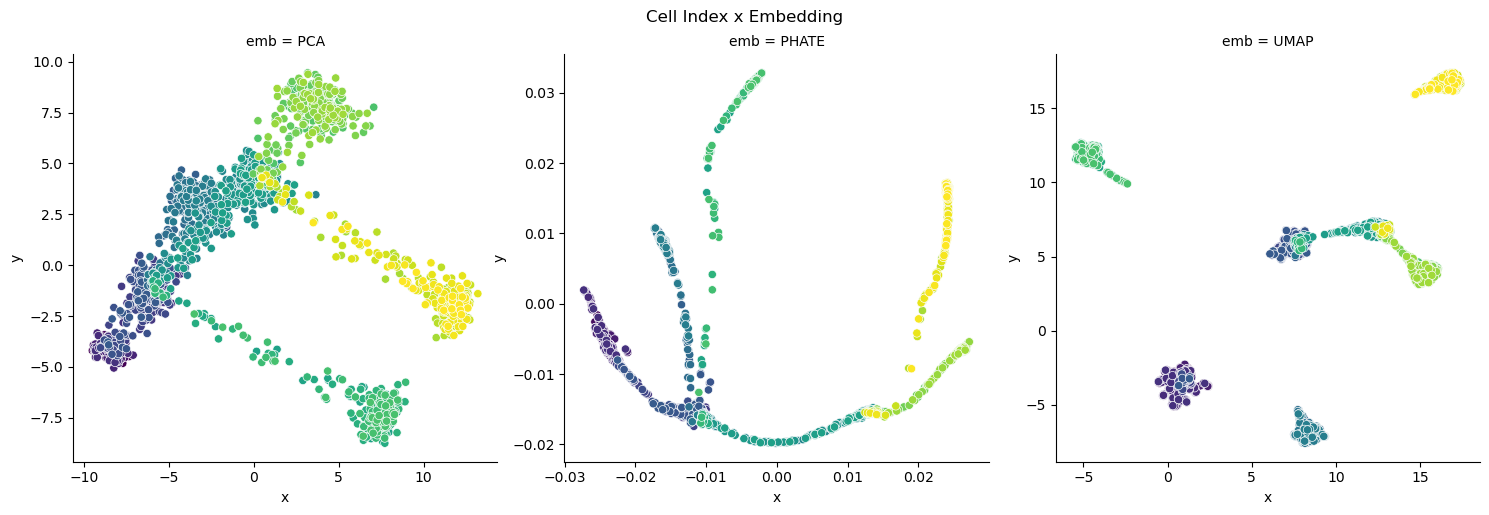

In [36]:
g = sns.relplot(
    df_embs, x='x', y='y', col="emb",  kind='scatter', 
    hue="barcode", legend=False, palette='viridis', 
    facet_kws={'sharey': False, 'sharex': False}, 
)
g.fig.suptitle("Cell Index x Embedding", y=1.02);

In [37]:
df.loc[:, 'pseudotime'] = (pseudotime * 500).astype(int)
df_phate.loc[:, 'pseudotime'] = (pseudotime * 500).astype(int).values

/var/folders/9p/5wgy7cdj0fqft1h3t3ssh_8r0000gn/T/ipykernel_49161/580545189.py:1: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'pseudotime'] = (pseudotime * 500).astype(int)
/var/folders/9p/5wgy7cdj0fqft1h3t3ssh_8r0000gn/T/ipykernel_49161/580545189.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_phate.loc[:, 'pseudotime'] = (pseudotime * 500).astype(int).values


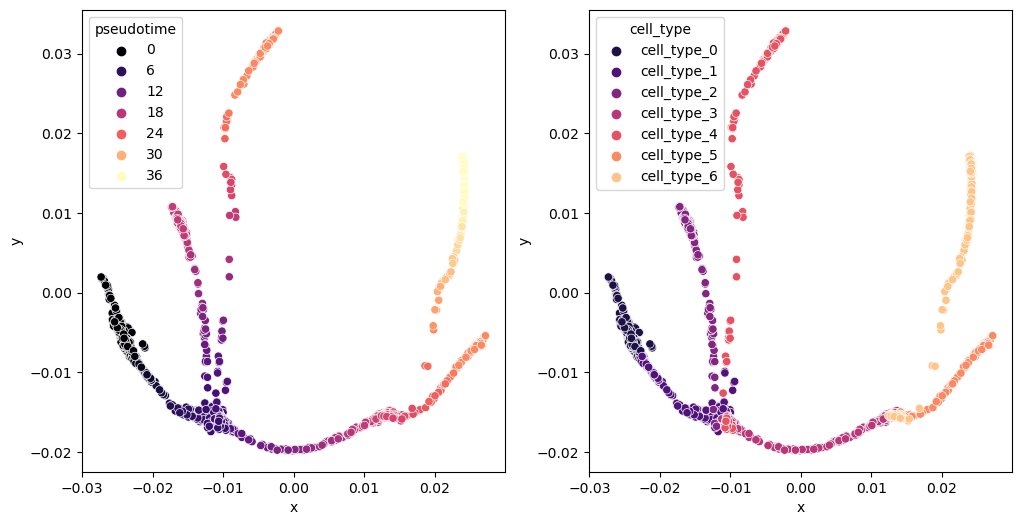

In [38]:
fig = plt.figure(figsize=(12, 6))
axes = fig.subplots(1, 2)

sns.scatterplot(
    df_phate, x='x', y='y', palette='magma', hue='pseudotime', ax=axes[0],
)

sns.scatterplot(
    df_phate, x='x', y='y', palette='magma', hue='cell_type', ax=axes[1],
);

In [39]:
df.to_pickle(os.path.expanduser('~/Downloads/sergio_tree_df.pkl'))
df_phate.to_pickle(os.path.expanduser('~/Downloads/sergio_tree_df_phate.pkl'))

# Make Graph

In [119]:
u, v = df_edges.values.T
u = torch.IntTensor(u)
v = torch.IntTensor(v)

g = dgl.graph((u, v))
g.ndata['feat'] = torch.Tensor(np.ones((len(g.nodes()), 1)))


ref_g = g.to_networkx()
ref_pos = nx.spring_layout(ref_g.to_undirected(), seed=seed)

for idx, node in enumerate(ref_g.nodes()):
    ref_g.nodes[idx]['color'] = plt.get_cmap('viridis', len(u))(idx)
    ref_g.nodes[idx]['label'] = df_data.columns[node].replace('gene_', '')

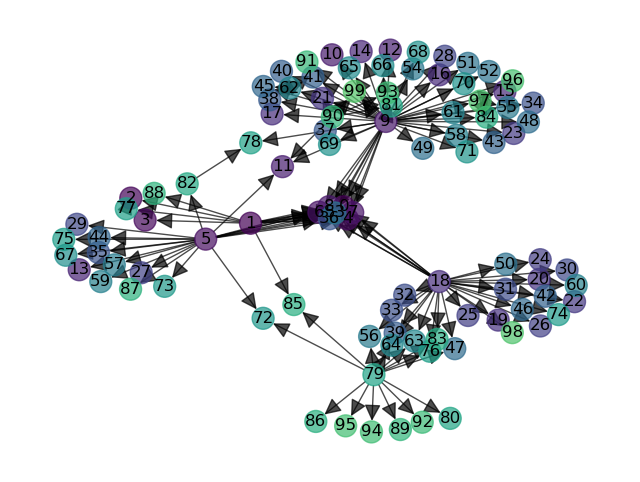

In [120]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1,1,1)

nx.draw_networkx_labels(
    ref_g, pos=ref_pos, ax=ax,
    labels=nx.get_node_attributes(ref_g,'label'),
    font_size=12, font_color='black'
)

nx.draw(
    ref_g, pos=ref_pos, ax=ax,
    with_labels=False,
    node_color=list(nx.get_node_attributes(ref_g, 'color').values()),
    edge_cmap=plt.cm.magma,
    node_size=250, arrowsize=25, alpha=0.7
)

# Graph ODE Stuff

In [121]:
# Mapping for edge ids
edge_ids = np.arange(g.number_of_edges())

# Shuffle
edge_ids = np.random.permutation(edge_ids)

test_size_percent = 30
test_size_fraction = test_size_percent / 100

edge_test_size = int(len(edge_ids) * test_size_fraction)
edge_train_size = g.number_of_edges() - edge_test_size

In [122]:
edge_test_pos_u = u[edge_ids[:edge_test_size]]
edge_test_pos_v = v[edge_ids[:edge_test_size]]

edge_train_pos_u = u[edge_ids[edge_test_size:]]
edge_train_pos_v = v[edge_ids[edge_test_size:]]

In [123]:
adjaceny_matrix = sp.coo_matrix(
    (np.ones(len(u)), (u.numpy(), v.numpy())),
    shape=(g.number_of_nodes(), g.number_of_nodes())
)

adjaceny_matrix_negative = 1 - adjaceny_matrix.todense() - np.eye(g.number_of_nodes())

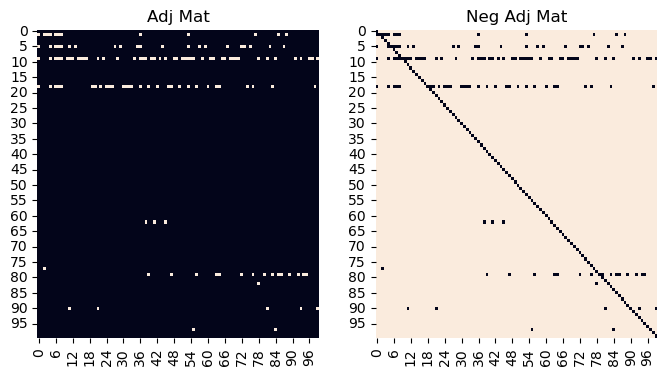

In [124]:
fig = plt.figure(figsize=(8, 4))
axes = fig.subplots(1, 2)

sns.heatmap(adjaceny_matrix.todense(), label='Adj Mat', ax=axes[0], cbar=False);
axes[0].set_title('Adj Mat');
sns.heatmap(adjaceny_matrix_negative, label='Neg Adj Mat', ax=axes[1], cbar=False);
axes[1].set_title('Neg Adj Mat');

In [125]:
neg_u, neg_v = np.where(adjaceny_matrix_negative != 0)
neg_edge_ids = np.random.choice(len(neg_u), g.number_of_edges())

edge_test_neg_u = neg_u[neg_edge_ids[:edge_test_size]]
edge_test_neg_v = neg_v[neg_edge_ids[:edge_test_size]]
edge_train_neg_u = neg_u[neg_edge_ids[edge_test_size:]]
edge_train_neg_v = neg_v[neg_edge_ids[edge_test_size:]]

In [126]:
train_g = dgl.remove_edges(g, edge_ids[:edge_test_size])

train_pos_g = dgl.graph(
    (edge_train_pos_u, edge_train_pos_v), 
    num_nodes=g.number_of_nodes()
)

train_neg_g = dgl.graph(
    (edge_train_neg_u, edge_train_neg_v), 
    num_nodes=g.number_of_nodes()
)

test_pos_g = dgl.graph(
    (edge_test_pos_u, edge_test_pos_v), 
    num_nodes=g.number_of_nodes()
)

test_neg_g = dgl.graph(
    (edge_test_neg_u, edge_test_neg_v), 
    num_nodes=g.number_of_nodes()
)

In [127]:
# train_g = dgl.add_self_loop(train_g)

# train_pos_g = dgl.add_self_loop(train_pos_g)
# train_neg_g = dgl.add_self_loop(train_neg_g)
# test_pos_g  = dgl.add_self_loop(test_pos_g)
# test_neg_g  = dgl.add_self_loop(test_neg_g)

In [128]:
def get_edges_from_graph(g):
    u, v = g.edges()
    u = u.numpy().tolist()
    v = v.numpy().tolist()
    edges = np.vstack((u, v)).T
    return edges

def get_missing_edges_from_edges(g):
    nodes = g.nodes().numpy().tolist()
    all_edges = list(itertools.product(nodes, nodes))
    edges = get_edges_from_graph(g).tolist()  
    return list(filter(lambda e: e not in edges, map(list, all_edges)))

In [129]:
import dgl.function as fn

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]
        
        
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        """
        Computes a scalar score for each edge of the given graph.

        Parameters
        ----------
        edges :
            Has three members ``src``, ``dst`` and ``data``, each of
            which is a dictionary representing the features of the
            source nodes, the destination nodes, and the edges
            themselves.

        Returns
        -------
        dict
            A dictionary of new edge features.
        """
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

In [130]:
from gode.odeblock import ODEBlock
from gode.gde import GDEFunc
from gode.dgl import DGLSAGEConv, DGLGATConv, MeanAttentionLayer

from gode.data import (
    make_mean_data_ti, make_train_test_dataframe, 
    get_data_ti, representative_cell_types_at_t,
    sample_group_index, sample_aggregate_group_at_t
)

def get_data_ti(
    df:pd.DataFrame, 
    t, 
    size:int,
    features,
    replace:bool=False,
    time_key:str='pseudotime',
    groupby:str='cell_types',
    device:torch.device=None
):
    if device is None:
        device = get_device()
        
    return torch.Tensor(
        sample_aggregate_group_at_t(
            df, t, time_key=time_key, 
            size=size, replace=replace,
            groupby=groupby, features=features
        ).values
    ).T#.to(device).T


In [131]:
def get_n_cells_of_type_k_at_time_t(df, n, k, t, genes=df_data.columns):
    n_genes = len(genes)
    groups = df.groupby(['cell_types', 'pseudotime'])
    if (k, t) not in groups.groups:
        values = np.array([[0 for cell in range(n)] for gene in range(n_genes)])
    else:
        values = groups.get_group((k, t))\
            .filter(genes).sample(n, replace=True)\
            .values.T
        
    # e.g. shape = (100 genes, 10 cells)
    genes_x_cells = values
    return genes_x_cells

In [132]:
def get_n_cells_of_all_types_at_time_t(df, n, t, types=np.unique(cell_types), genes=df_data.columns):
    return np.hstack(tuple([
        get_n_cells_of_type_k_at_time_t(df, n, k, t, genes=genes)
        for k in types
    ]))


In [133]:
df_train, df_test = make_train_test_dataframe(df)

In [134]:
get_n_cells_of_type_k_at_time_t(df_train, 10, 'cell_type_0', 0).shape

(100, 10)

In [135]:
get_n_cells_of_all_types_at_time_t(df_train, 10, 0).shape

(100, 70)

In [136]:
np.hstack(tuple([
    get_n_cells_of_type_k_at_time_t(df_train, 10, 'cell_type_0', 0)
    for i in range(2)
])).shape

(100, 20)

In [137]:
n_cells_at_t = 4

In [138]:
time_bins = np.sort(df.pseudotime.unique())
cell_types = np.sort(df.cell_types.unique())

t0, *_, tn = time_bins
time_tensor = torch.Tensor(time_bins)#.to(device)

in_feats = cell_types.size * n_cells_at_t
out_feats = cell_types.size * n_cells_at_t

In [139]:
nodes_names = [df_data.columns[i] for i in train_g.nodes().numpy()]
node_map_full = {n:i for i, n in enumerate(nodes_names)}
tfs = 'gene_0 gene_10 gene_20 gene_30'.split()

In [140]:
class DGLGATConv(conv.GATConv):
    def __init__(self, graph, in_feats, out_feats, num_heads, feat_drop=0.0, attn_drop=0.0, negative_slope=0.2, residual=False, activation=None, allow_zero_in_degree=False, bias=True):
        super(DGLGATConv, self).__init__(in_feats, out_feats, num_heads, feat_drop, attn_drop, negative_slope, residual, activation, allow_zero_in_degree, bias)
        self.graph = graph

    def forward(self, feat, get_attention=False):
        return super().forward(self.graph, feat, get_attention)

In [180]:
gnn = nn.Sequential( 
    DGLGATConv(
        train_g,
        in_feats=in_feats, out_feats=out_feats, 
        num_heads=1, residual=False,
        activation=nn.Tanh(),
        feat_drop=0.0, attn_drop=0.0,
        allow_zero_in_degree=True
    ),
    MeanAttentionLayer(),
)

gdefunc = GDEFunc(gnn)
gde = ODEBlock(func=gdefunc, method='rk4', atol=1e-3, rtol=1e-4, adjoint=False).to(device)
model = gde

In [181]:
pred = DotPredictor()

def compute_link_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [182]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.1, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=350, gamma=0.1)
criterion = torch.nn.MSELoss()

steps = 1000
verbose_step = 5

lambda_l1 = 0.5

In [183]:
from gode.plots import custom_features_over_time
from gode.data import make_results_dataframe, get_spearmanr

In [184]:
add_n = 5
del_n = 5
link_step = 2

In [185]:
sample_size = 10

In [186]:
data_t0 = get_n_cells_of_all_types_at_time_t(df_train, n_cells_at_t, 0)
# data_t1 = get_n_cells_of_all_types_at_time_t(df_train, n_cells_at_t, _t + 1) 

In [187]:
data_t0.shape

(100, 28)

In [ ]:
attentions = {}

for step_i in range(steps):   
    
    data_tps = []
    data_tis = []
    for _t, time_i in enumerate(time_bins[:-1]):    
        
#         data_t0 = get_data_ti(df_train, _t, sample_size, df_data.columns, replace=True)
#         data_t1 = get_data_ti(df_train, _t+1, sample_size, df_data.columns, replace=True)
        
        data_t0 = get_n_cells_of_all_types_at_time_t(df_train, n_cells_at_t, _t)
        data_t1 = get_n_cells_of_all_types_at_time_t(df_train, n_cells_at_t, _t + 1)        
        data_t0 = torch.Tensor(data_t0)#.to(device)
        data_t1 = torch.Tensor(data_t1)#.to(device)
        
        t0 = time_bins[_t]
        t1 = time_bins[_t + 1]
        
        model.train()        
        data_tp = model(
            data_t0,  
            torch.Tensor([t0, t1]),#.to(device), 
            return_whole_sequence=False
        )    
                
        pos_score = pred(train_pos_g, data_tp)
        neg_score = pred(train_neg_g, data_tp)
        link_loss = compute_link_loss(pos_score, neg_score)
        
        _, attn = model.func.gnn[0](data_t0, get_attention=True)
    
        loss = criterion(data_tp, data_t1) + 10 * link_loss # + lambda_l1 * torch.norm(attn, 1)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if _t == 0:
            data_tis.append(data_t0.clone().detach())
        data_tis.append(data_t1.clone().detach())
        data_tps.append(data_tp.clone().detach())
        
    
    if step_i % link_step == 0:
        model.eval()
        with torch.no_grad():
            # HANDLE LINKS
            # Find edges to add
            missing_edges = np.array(get_missing_edges_from_edges(train_g)).T
            missing_u, missing_v = missing_edges

            missing_g = dgl.graph(
                (torch.IntTensor(missing_u), torch.IntTensor(missing_v)), 
                num_nodes=g.number_of_nodes()
            )

            missing_score = pred(missing_g, data_tp)
            missing_idxs = np.argsort(missing_score.numpy())

            best_u = missing_u[missing_idxs[-add_n:]]
            best_v = missing_v[missing_idxs[-add_n:]]


            # Find edges to remove
            current_u, current_v = get_edges_from_graph(train_g).T

            current_scores = pred(train_g, data_tp)
            current_idxs = np.argsort(current_scores.numpy())

            worst_u = current_u[current_idxs[:del_n]]
            worst_v = current_v[current_idxs[:del_n]]

            to_remove = train_g.edge_ids(torch.IntTensor(worst_u), torch.IntTensor(worst_v))
    
            train_g.remove_edges(to_remove)
            train_g.add_edges(torch.IntTensor(best_u), torch.IntTensor(best_v))

        

        
        
        
    scheduler.step()   
    
    if step_i % verbose_step == 0:
        model.eval()
        with torch.no_grad():
            
#         data_t0 = get_data_ti(df_train, _t, sample_size, df_data.columns, replace=True)
#         data_t1 = get_data_ti(df_train, _t+1, sample_size, df_data.columns, replace=True)
        
            data_t0 = get_n_cells_of_all_types_at_time_t(df_train, n_cells_at_t, _t)
            data_t1 = get_n_cells_of_all_types_at_time_t(df_train, n_cells_at_t, _t + 1)        
            data_t0 = torch.Tensor(data_t0)#.to(device)
            data_t1 = torch.Tensor(data_t1)#.to(device)
        
            data_tp = model(data_t0,  time_tensor, return_whole_sequence=True)

        
            pos_score = pred(test_pos_g, data_tp[-1])
            neg_score = pred(test_neg_g, data_tp[-1])
            auc_score = compute_auc(pos_score, neg_score)
            print('[{}],\t Loss: {:3.5f},\t AUC: {:3.5f}'.format(step_i + 1, loss, auc_score)) 


                
        
            attns = np.empty(0)
            data_tp = data_tps
            data_tps = []
            data_tis = []
            for _t, time_i in enumerate(time_bins[:-1]): 
#         data_t0 = get_data_ti(df_train, _t, sample_size, df_data.columns, replace=True)
#         data_t1 = get_data_ti(df_train, _t+1, sample_size, df_data.columns, replace=True)

                data_t0 = get_n_cells_of_all_types_at_time_t(df_train, n_cells_at_t, _t)
                data_t1 = get_n_cells_of_all_types_at_time_t(df_train, n_cells_at_t, _t + 1)        
                data_t0 = torch.Tensor(data_t0)#.to(device)
                data_t1 = torch.Tensor(data_t1)#.to(device)

                t0 = time_bins[_t]
                t1 = time_bins[_t + 1]

                data_tp = model(
                    data_t0,  
                    torch.Tensor([t0, t1]),#.to(device), 
                    return_whole_sequence=False
                )    




                if _t == 0:
                    data_tis.append(data_t0.clone().detach())
                data_tis.append(data_t1.clone().detach())
                data_tps.append(data_tp.clone().detach())

                _, attn = model.func.gnn[0](data_t0, get_attention=True)

                attn = attn.reshape(-1).detach().cpu().numpy()        
                attns = np.vstack((attns, attn)) if attns.size else attn

            attns = np.array(attns)
            
            if step_i in np.arange(0, steps, 10):#[0, int(steps/2), steps-1]:
                data_ti = torch.Tensor(np.array([t.detach().cpu().numpy() for t in data_tis]))
                data_tp = torch.Tensor(np.array([t.detach().cpu().numpy() for t in data_tps]))
                
                dti = data_ti.detach().numpy()
                dtp = data_tp.detach().numpy()
                
                idx = np.arange(num_cell_types) * n_cells_at_t - 1
                idx[0] = 0
                
                dti_t = torch.Tensor(dti[:, :, idx])
                dtp_t = torch.Tensor(dtp[:, :, idx])
                
                df_res = make_results_dataframe(
                    dti_t, dtp_t, 
                    nodes_names, cell_types, tfs
                )
                
                df_corr = get_spearmanr(dti_t, dtp_t, columns=cell_types, index=node_map_full)
                
                fig = custom_features_over_time(
                    df_res, df_corr,
                    col='tf', row='cell_type',
                    hue='type', x='time', y='expression'
                )            
                fig.savefig(os.path.join(DATA_DIR, f'{n_cells_at_t}_cells_expression_epoch_{step_i}.png'))
                
                
                nx_g = train_g.to_networkx()

                fig = plt.figure(figsize=(8, 6))
                ax = fig.add_subplot(1,1,1)

                nx.draw_networkx_labels(
                    nx_g, pos=ref_pos, ax=ax,
                    labels=nx.get_node_attributes(ref_g,'label'),
                    font_size=12, font_color='black'
                )

                nx.draw(
                    nx_g, pos=ref_pos, ax=ax,
                    with_labels=False,
                    node_color=list(nx.get_node_attributes(ref_g, 'color').values()),
                    edge_cmap=plt.cm.magma,
                    node_size=500, arrowsize=25, alpha=0.7
                )
                
                fig.savefig(os.path.join(DATA_DIR, f'{n_cells_at_t}_cells_graph_epoch_{step_i}.png'))
                
                attentions[step_i] = np.array(attns)
                
                
            data_tp = np.array([t.detach().cpu().numpy() for t in data_tps])

array([0])

In [151]:
data_ti = torch.Tensor(np.array([t.detach().cpu().numpy() for t in data_tis]))
data_tp = torch.Tensor(np.array([t.detach().cpu().numpy() for t in data_tps]))

In [152]:
dti = data_ti.detach().numpy()
dtp = data_tp.detach().numpy()

In [156]:
idx = np.arange(num_cell_types) * n_cells_at_t - 1
idx[0] = 0
idx

array([ 0,  3,  7, 11, 15, 19, 23])

In [157]:
dti_t = torch.Tensor(dti[:, :, idx])
dtp_t = torch.Tensor(dtp[:, :, idx])

In [158]:
df_res = make_results_dataframe(
    dti_t, dtp_t, 
    nodes_names, cell_types, tfs
)


In [159]:
df_corr = get_spearmanr(dti_t, dtp_t, columns=cell_types, index=node_map_full)

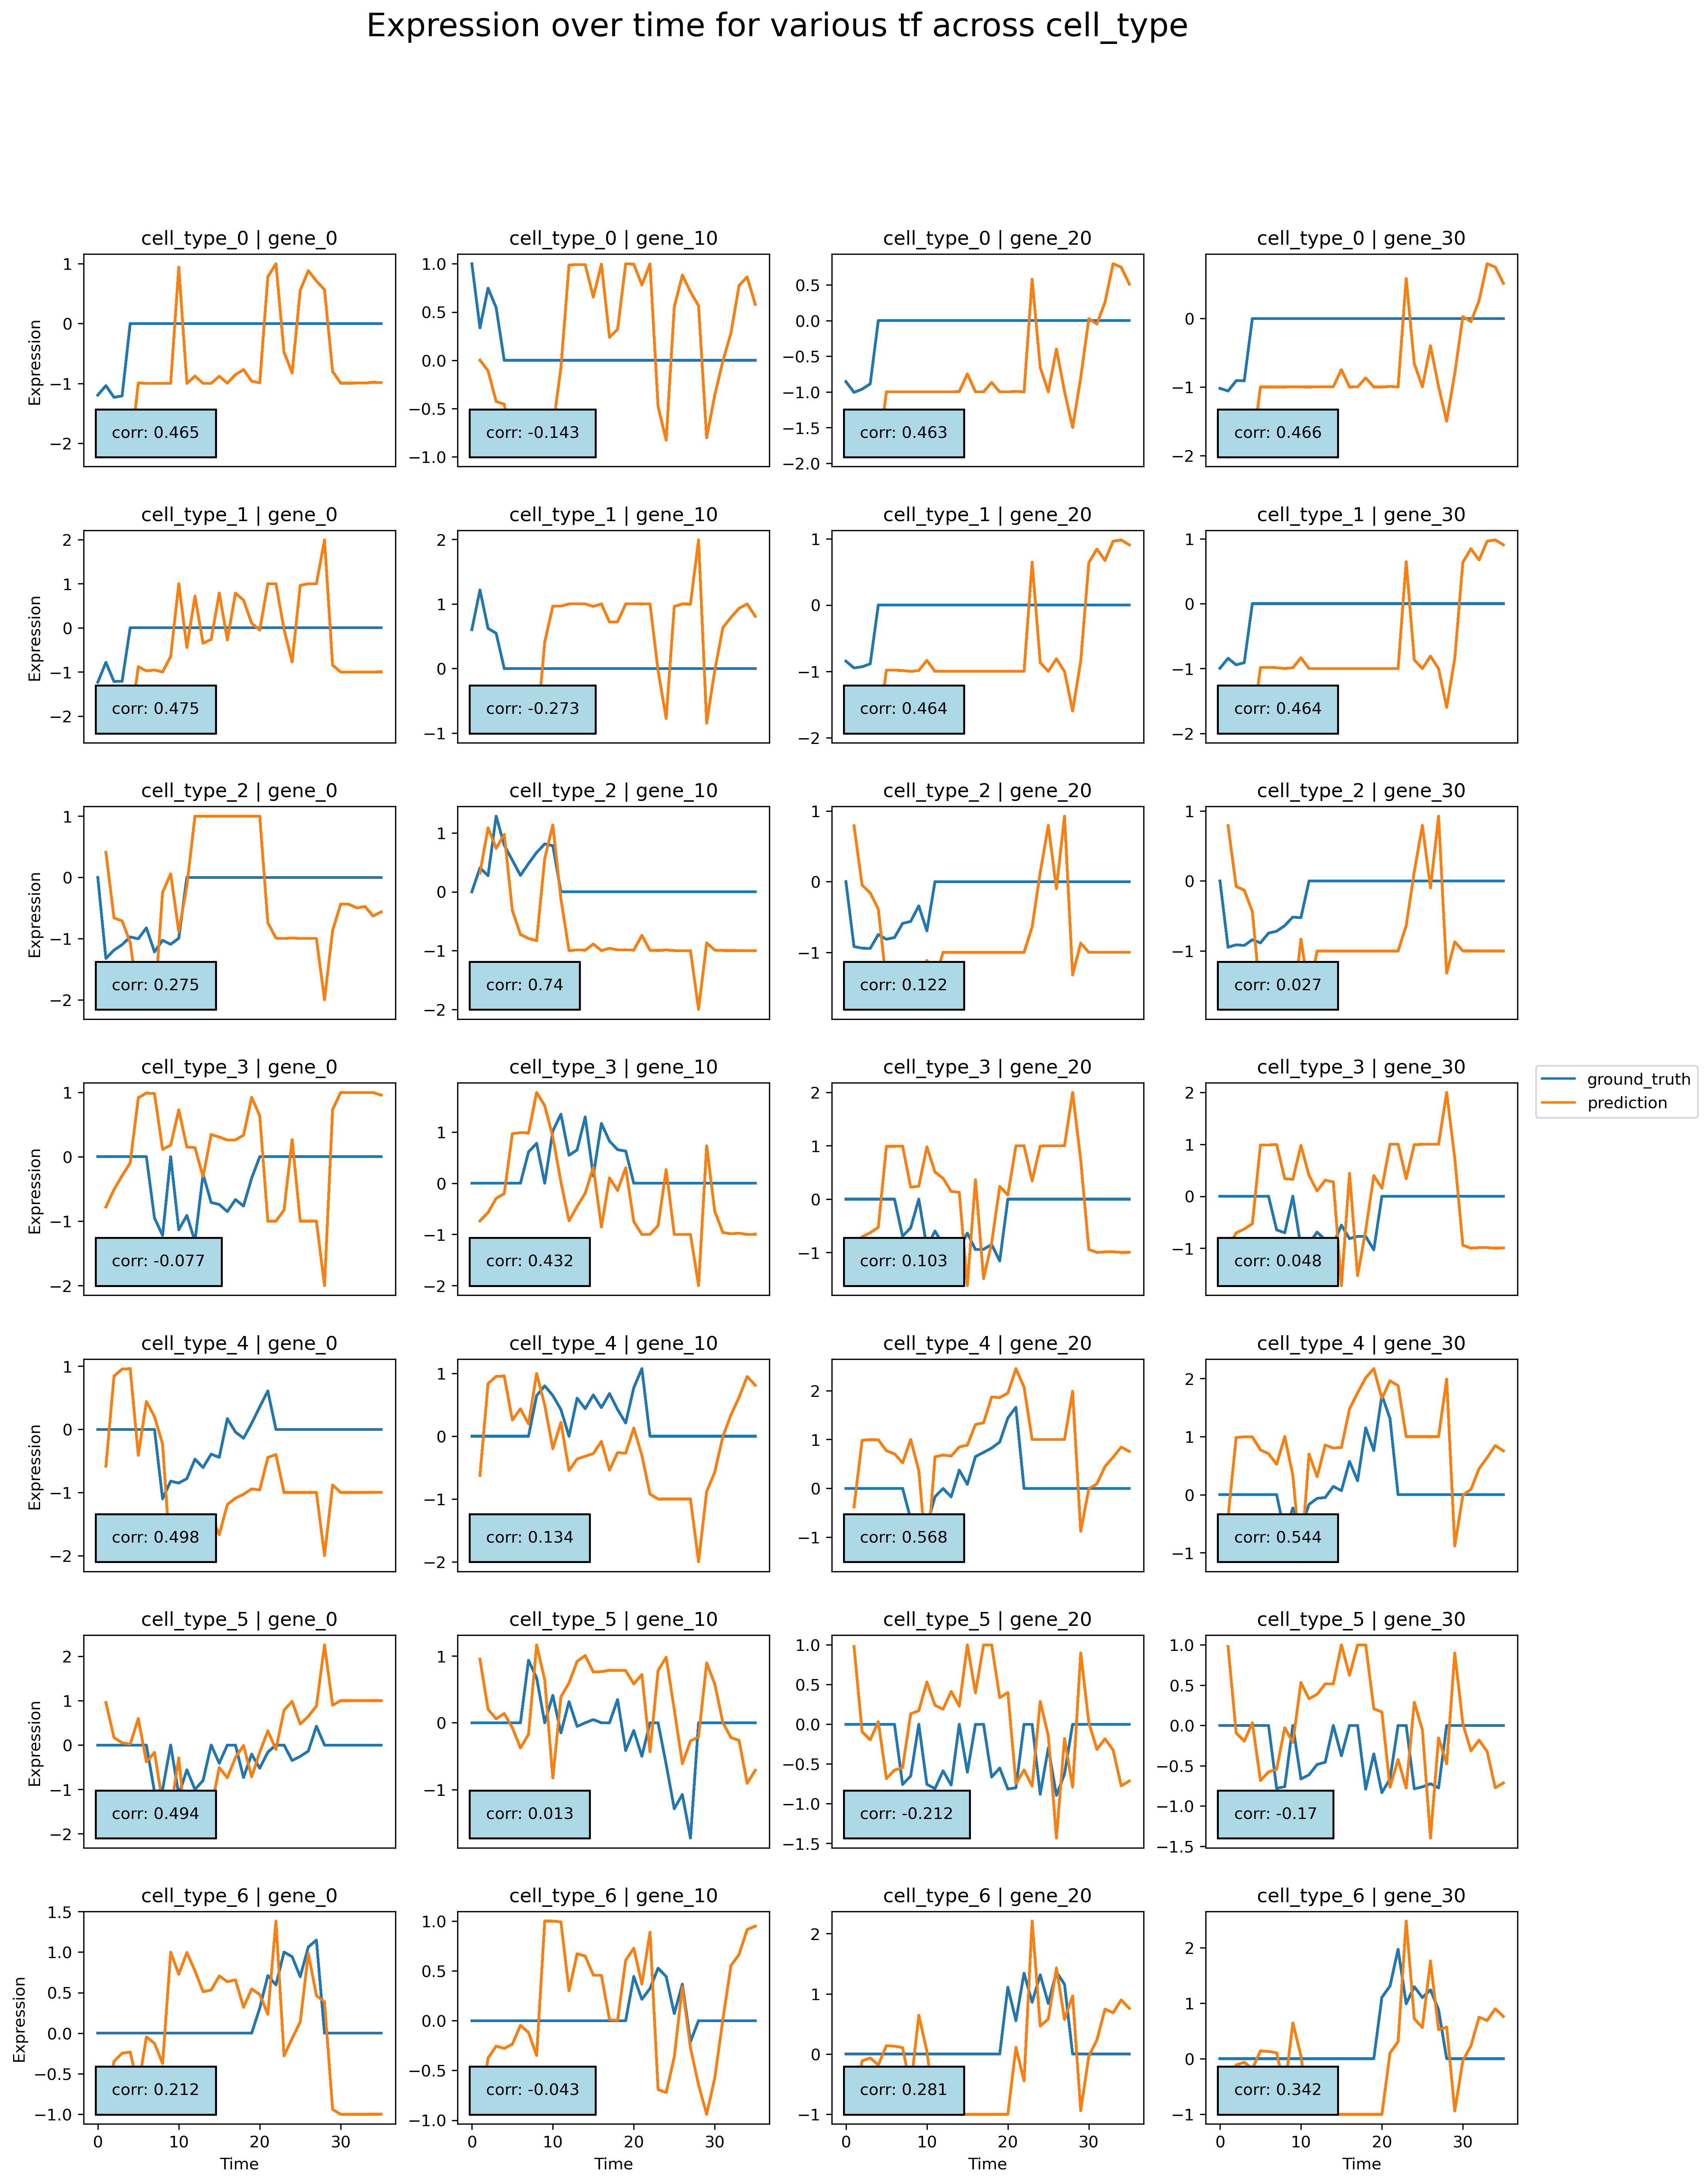

In [160]:
fig = custom_features_over_time(
    df_res, df_corr,
    col='tf', row='cell_type',
    hue='type', x='time', y='expression'
)            

In [300]:
nx_g = train_g.to_networkx()
# pos = nx.kamada_kawai_layout(nx_g, scale=1, dim=2)

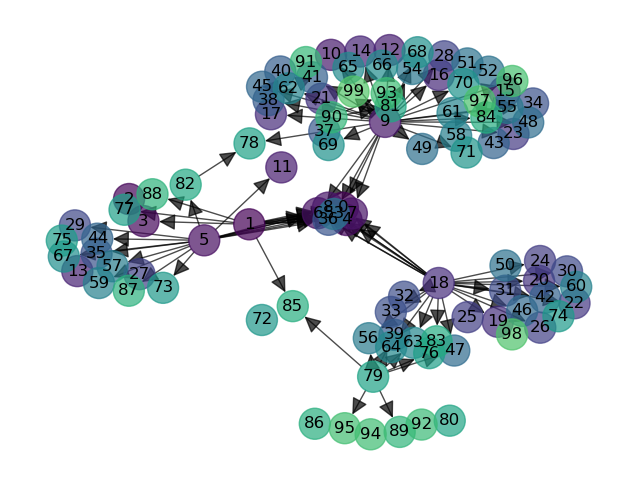

In [163]:
nx_g = train_g.to_networkx()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1,1,1)

nx.draw_networkx_labels(
    nx_g, pos=ref_pos, ax=ax,
    labels=nx.get_node_attributes(ref_g,'label'),
    font_size=12, font_color='black'
)

nx.draw(
    nx_g, pos=ref_pos, ax=ax,
    with_labels=False,
    node_color=list(nx.get_node_attributes(ref_g, 'color').values()),
    edge_cmap=plt.cm.magma,
    node_size=500, arrowsize=25, alpha=0.7
)

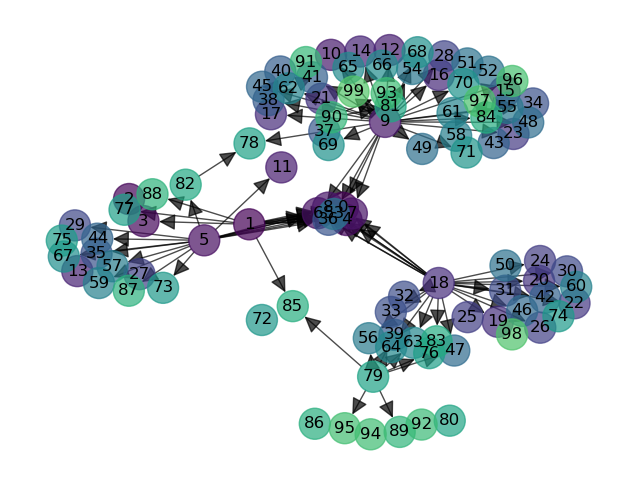

In [197]:
len(train_g.edges()[0])

96

In [287]:
data_ti.shape

(38, 100, 4)

In [183]:
train_pos_g

Graph(num_nodes=100, num_edges=96,
      ndata_schemes={}
      edata_schemes={})

In [144]:
train_g.remove_edges(train_g.edge_ids(train_g.edges()[0][:100], train_g.edges()[1][:100]))

In [145]:
len(train_g.edges()[0])

11294

In [146]:
train_g.remove_self_loop()

Graph(num_nodes=100, num_edges=540,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={})